In [1]:
import numpy as np
import torch
from torch import nn
import os
from numpy import *
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold 
import pandas as pd
from matplotlib.pyplot import MultipleLocator
import decoding 
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.autograd import Variable
import analysis
import timevarying
# import shaping # skip shaping if not computing SHAP value

In [2]:
data_behavior=np.load('./demo_session_behavior.npy',allow_pickle=True)
data_control=np.load('./demo_session_control.npy',allow_pickle=True)

torch.random.manual_seed(1) # for reproducing
np.random.seed(1)

In [3]:
########### hyper parameter setting for standard RNN ###########
lr=0.0001
epochs=100 # epochs for training RNN-S1
en_epochs=20 # epochs for training RNN-S2, the training is very slow, keep #epochs small if unnecessary
batch_size=5
min_t=600 # The overall #time points is 1800 for 60 secs, so 600-900 means -10s before the behavior to the behavior. 
max_t=900
########### hyper parameter setting for TV RNN ############
lr_tv=0.0001
epochs_tv=100
batch_size_tv=128
num_tv=10
num_fold=5
t_ind_ini=np.linspace(0,max_t-min_t,num_tv+1).astype(int)
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
###########################################
data_input,data_label=decoding.data_processing(data_behavior,data_control)
data_input=data_input[:,min_t:max_t,:]
data_input=torch.tensor(data_input,dtype=dtype,device=device)
data_label=torch.tensor(data_label,dtype=dtype,device=device)
input_s=data_input.shape[2]

kf = KFold(n_splits=num_fold,random_state=42, shuffle=True)
vi_s=0
save_val_S1=[]
save_val_S2=[]
save_val_tv=[]

for train_index, test_index in kf.split(data_input):
    print('start:',vi_s)
    vi_s=vi_s+1
    X_t_train, X_t_test = data_input[train_index], data_input[test_index] 
    y_t_train, y_t_test = data_label[train_index], data_label[test_index]
    model_en,acc_en_all,val_en_all,loss_en_all,en_accuracy,en_val_accuracy,en_output_train,en_output_test=decoding.rnn_model(lr,
                                                                        en_epochs,
                                                                        batch_size,
                                                                        X_t_train,
                                                                        y_t_train,
                                                                        X_t_test,
                                                                        y_t_test,
                                                                        using_all=True,
                                                                        out_all=True,
                                                                        verbose=True,
                                                                        device=device)
    model_last,acc_all,val_all,loss_all,accuracy,val_accuracy,output_train,output_test=decoding.rnn_model(lr,
                                                                        epochs,
                                                                        batch_size,
                                                                        X_t_train,
                                                                        y_t_train,
                                                                        X_t_test,
                                                                        y_t_test,
                                                                        using_all=False,
                                                                        out_all=True,
                                                                        verbose=True,
                                                                        device=device)
    model_tv,acc_all_temp,val_acc_all_temp,loss_dy_each,loss_val,tv_output_train,tv_output_test=timevarying.rnn_model(lr_tv,
                                                                                   epochs_tv,
                                                                                   batch_size_tv,
                                                                                   t_ind_ini,
                                                                                   num_tv,
                                                                                   X_t_train,
                                                                                   y_t_train,
                                                                                   X_t_test,
                                                                                   y_t_test,
                                                                                   model_last,
                                                                                   verbose=True,
                                                                                   device=device)
    save_val_S1.append(val_accuracy)
    save_val_S2.append(en_val_accuracy)
    save_val_tv.append(val_acc_all_temp)
save_val_S1=np.array(save_val_S1)
save_val_S2=np.array(save_val_S2)
save_val_tv=np.array(save_val_tv)

start: 0
Epoch 1/20, loss = 207.85437844606008,accuracy=0.514792899408284, val_accuracy=0.4418604651162791
Epoch 2/20, loss = 207.84894776870223,accuracy=0.514792899408284, val_accuracy=0.4418604651162791
Epoch 3/20, loss = 207.861936639337,accuracy=0.514792899408284, val_accuracy=0.4418604651162791
Epoch 4/20, loss = 207.83383633284006,accuracy=0.514792899408284, val_accuracy=0.4418604651162791
Epoch 5/20, loss = 207.7940863090403,accuracy=0.514792899408284, val_accuracy=0.4418604651162791
Epoch 6/20, loss = 207.83392740698423,accuracy=0.514792899408284, val_accuracy=0.4418604651162791
Epoch 7/20, loss = 207.7701353974202,accuracy=0.514792899408284, val_accuracy=0.4418604651162791
Epoch 8/20, loss = 207.7668727566214,accuracy=0.514792899408284, val_accuracy=0.4418604651162791
Epoch 9/20, loss = 207.78964341037414,accuracy=0.514792899408284, val_accuracy=0.4418604651162791
Epoch 10/20, loss = 207.7214481497512,accuracy=0.514792899408284, val_accuracy=0.4418604651162791
Epoch 11/20, los

In [4]:
################!!!These will take a very long time!!! Please skip if unneccessary!!!########################
# shap_value_ori=shaping.get_shap_ori(model_last.state_dict(),X_t_train,X_t_test) # SHAP value of RNN-S1
# shap_value=shaping.get_shap(model.state_dict(),X_t_train,X_t_test,num_tv) # SHAP value of TV RNN
#############################################################################################################

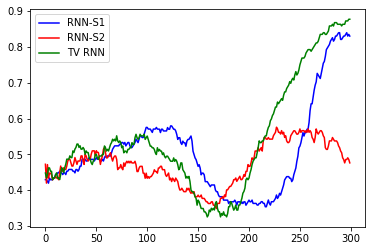

In [5]:
plt.plot(np.mean(save_val_S1,axis=0),label='RNN-S1',color='blue')
plt.plot(np.mean(save_val_S2,axis=0),label='RNN-S2',color='red')
plt.plot(np.mean(save_val_tv,axis=0),label='TV RNN',color='green')
plt.legend()
plt.show()

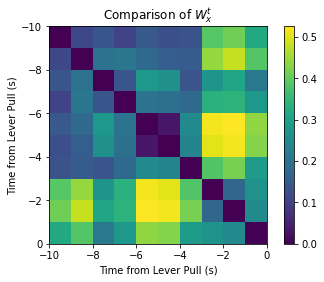

In [6]:
ed_hh,ed_ih,ed_hh_b,ed_ih_b,ed_o,ed_o_b=analysis.weights_analysis(model_tv)
plt.imshow(ed_ih,extent=[-10,0,0,-10])
cbar=plt.colorbar()
plt.xlabel('Time from Lever Pull (s)')
plt.ylabel('Time from Lever Pull (s)')
plt.title('Comparison of '+r'$W_{x}^{t}$')
plt.show()